In [1]:
import xarray as xr
import fsspec

## Install/Update packages and Load common functions

In [ ]:
# only run once, then restart session and comment the next 3 lines
!pip install s3fs -U
!pip install zarr xarray[complete] -U

In [2]:
# remote zarr dataset
dataset_name="srs_l3s_1d_dn"
url = f's3://imos-data-lab-optimised/parquet/loz_test/{dataset_name}.zarr/'
ds = xr.open_zarr(fsspec.get_mapper(url, anon=True), consolidated=True)
ds

<xarray.Dataset> Size: 202GB
Dimensions:                            (time: 104, lat: 4500, lon: 6000)
Coordinates:
  * lat                                (lat) float32 18kB 19.99 19.97 ... -69.99
  * lon                                (lon) float32 24kB 70.01 70.03 ... 190.0
  * time                               (time) datetime64[ns] 832B 2024-01-01T...
Data variables: (12/18)
    dt_analysis                        (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    filename                           (time) <U54 22kB dask.array<chunksize=(1,), meta=np.ndarray>
    l2p_flags                          (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    quality_level                      (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    satellite_zenith_angle             (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    sea_ice_fraction                   (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    ...                                 ...
    sst_count                          (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    sst_dtime                          (time, lat, lon) float64 22GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    sst_mean                           (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    sst_standard_deviation             (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed                         (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    wind_speed_dtime_from_sst          (time, lat, lon) float32 11GB dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.6
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    Metadata_Link:              TBA
    acknowledgment:             Any use of these data requires the following ...
    cdm_data_type:              grid
    comment:                    HRPT AVHRR experimental L3 retrieval produced...
    ...                         ...
    summary:                    Skin SST retrievals produced from stitching t...
    time_coverage_end:          20240413T165456Z
    time_coverage_start:        20240412T232018Z
    title:                      IMOS L3S Day and Night gridded multiple-senso...
    uuid:                       0486b68d-00cc-4643-bbdf-831627b18798
    westernmost_longitude:      70.01000213623047

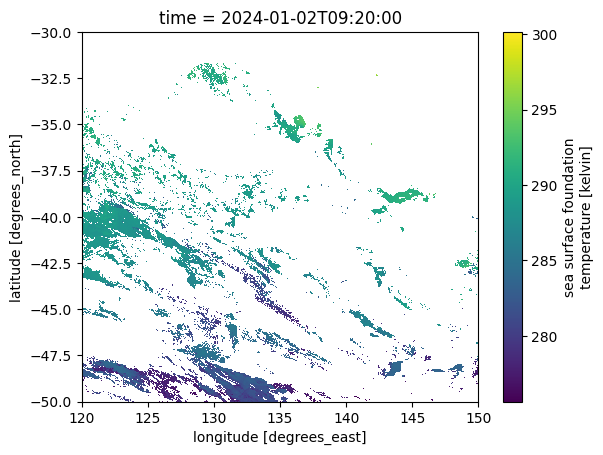

In [3]:
ds.sea_surface_temperature.sel(time='2024-01-02', lon=slice(120, 150), lat=slice(-30, -50)).plot()

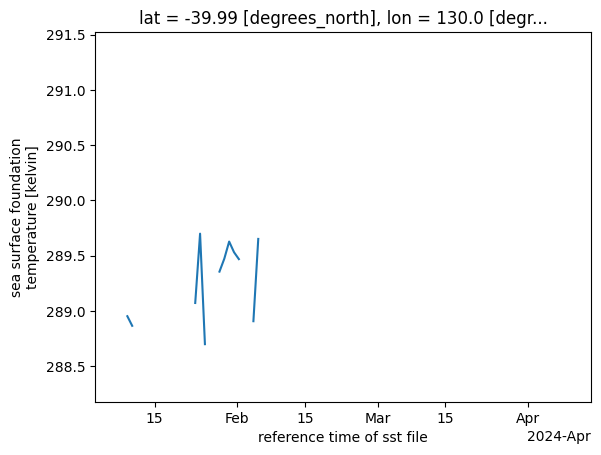

In [4]:
ds.sea_surface_temperature.sel(lat=-40, lon=130, method='nearest').plot()